In [74]:
from os.path import abspath
from pyspark.sql import SparkSession
from pyspark.sql import functions as F
import os
import sys
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import inspect

In [75]:
os.environ['PYSPARK_DRIVER_PYTHON_OPTS']= "notebook"
os.environ['PYSPARK_DRIVER_PYTHON'] = sys.executable
os.environ['PYSPARK_PYTHON'] = sys.executable

spark = SparkSession \
    .builder \
    .appName("renovation") \
    .getOrCreate()

# set this parameter for date issue before 1582 (dpe database)
spark.conf.set("spark.sql.legacy.timeParserPolicy","LEGACY")

In [76]:
# create database
# File location and type
file_location_array = [
    {"location" : "../../training/pred_tremi_full.csv", "name": "pred_tremi_full", "delimiter": ","},
    {"location" :  "../../training/training_dpe.csv", "name": "training_dpe", "delimiter": ","},
    {"location" :  "../../training/prediction_dpe.csv", "name": "prediction_dpe", "delimiter": ","},
    {"location" :  "../../training/dico.csv", "name": "dictionary", "delimiter": "\t"}
]
file_type = "csv"

# CSV options
infer_schema = "true"
first_row_is_header = "true"
dataframes = {}

# The applied options are for CSV files. For other file types, these will be ignored.
for file in file_location_array:
    delimiter = file["delimiter"]
    file_location = file["location"]
    name = file["name"]
    dataframes[file["name"]] = (
        spark.read.format(file_type) \
        .option("inferSchema", infer_schema)
        .option("header", first_row_is_header)
        .option("sep", delimiter)
        .load(file_location)
    )
    dataframes[file["name"]].show()

+------+---+----------+----------+---------------+------+----------+---------------------+----------------------+---------------+---------------------+-----------------+-------+------------------+----------------+
|gender|age|occupation|home_state|nb_persons_home|income|population|n_development_licence|n_construction_licence|n_new_buildings|n_destruction_licence|department_number|surface|heating_production|heating_emission|
+------+---+----------+----------+---------------+------+----------+---------------------+----------------------+---------------+---------------------+-----------------+-------+------------------+----------------+
|     0| 39|        13|         0|              3|     4|     12368|                    4|                    41|             43|                    0|               50|   null|              null|            null|
|     1| 26|        14|         0|              1|     1|    115934|                    5|                    78|            702|               

In [77]:
training_tremi = (
    dataframes['pred_tremi_full'].withColumns({
        'surface' : F.col('surface').cast('float'),
        'heating_production' : F.col('heating_production').cast('int'),
        'heating_emission' : F.col('heating_emission').cast('int')
    })
)

dictionary = dataframes['dictionary']

In [78]:

training_surf = training_tremi.filter(F.col('surface').isNotNull()).drop('heating_emission', 'heating_production')
predicting_surf = training_tremi.filter(F.col('surface').isNull()).drop('heating_emission', 'heating_production')

training_prod = training_tremi.filter(F.col('heating_production').isNotNull()).drop('heating_emission', 'surface')
predicting_prod = training_tremi.filter(F.col('heating_production').isNull()).drop('heating_emission', 'surface')

training_em = training_tremi.filter(F.col('heating_emission').isNotNull()).drop('surface', 'heating_production')
predicting_em = training_tremi.filter(F.col('heating_emission').isNull()).drop('surface', 'heating_production')

print(training_surf.count(), predicting_surf.count(), training_prod.count(), predicting_prod.count(), training_em.count(), predicting_em.count())

12565 26933 11128 28370 12558 26940


In [88]:
# get the name of  variable outside fonction
def retrieve_name(var):
    callers_local_vars = inspect.currentframe().f_back.f_back.f_locals.items()
    return [var_name for var_name, var_val in callers_local_vars if var_val is var]

# cut variable name if too long
def cut(name):
    if isinstance(name, str) and len(name)>10:
        return name[0:10]
    return name

# get all values in dict form
def get_dict(df):
    col_names = [col[0] for col in df.dtypes]
    values = {}
    rows = df.collect()
    for col_name in col_names:
        values[col_name] = [cut(row[col_name]) for row in rows]
    return values

# get labels for a variable thanks to dictionary
def get_labels(variable):
    study = (
        dictionary.filter(
            F.col('column') == variable
        )
        .select(
            F.col('value'),
            F.col('meaning')
        )
        .dropDuplicates()
        .orderBy('value')
    )
    return get_dict(study)

# return ticks for pie
def get_percent(value, values):
    total = sum(values)
    if len(values) < 5:
        return f'{value/100*total:.0f}\n{value:.2f}%'
    else:
        return f'{value:.1f}'

# plot pie
def plot_repartition(df, variable, ax, title=None):
    labels = get_labels(variable)['meaning']
    if len(labels) > 5:
        print(labels)
    count = get_dict(df.groupBy(variable).count().orderBy(variable))['count']
    ax.pie(count, labels = labels, autopct=lambda x: get_percent(x,count),startangle=90)
    if title:
        ax.set_title(title)

def plot_hist:

# plot multiple pies
def compare_repartition(dfs, variable):
    f, ax = plt.subplots(1, len(dfs), figsize=(20,20))
    plt.subplots_adjust(wspace=0.8)
    for i, df in enumerate(dfs):
        plot_repartition(df, variable, ax[i], retrieve_name(df))

['Non, retra', 'Cadre d’en', 'Profession', 'Profession', 'Technicien', 'Employé de', 'Ouvrier da', 'Non, à la ', 'Non, élève', 'Non, femme', 'Non, autre', 'Agriculteu', 'Artisan, c', 'Profession', 'Cadre de l']
['Non, retra', 'Cadre d’en', 'Profession', 'Profession', 'Technicien', 'Employé de', 'Ouvrier da', 'Non, à la ', 'Non, élève', 'Non, femme', 'Non, autre', 'Agriculteu', 'Artisan, c', 'Profession', 'Cadre de l']
['Non, retra', 'Cadre d’en', 'Profession', 'Profession', 'Technicien', 'Employé de', 'Ouvrier da', 'Non, à la ', 'Non, élève', 'Non, femme', 'Non, autre', 'Agriculteu', 'Artisan, c', 'Profession', 'Cadre de l']
['Non, retra', 'Cadre d’en', 'Profession', 'Profession', 'Technicien', 'Employé de', 'Ouvrier da', 'Non, à la ', 'Non, élève', 'Non, femme', 'Non, autre', 'Agriculteu', 'Artisan, c', 'Profession', 'Cadre de l']
['Moins de 1', 'De 14 000 ', 'De 19 000 ', 'De 25 000 ', 'De 31 700 ', 'De 40 000 ', 'De 50 000 ', 'De 60 000 ', '70 000 € p']
['Moins de 1', 'De 14 000 ', 

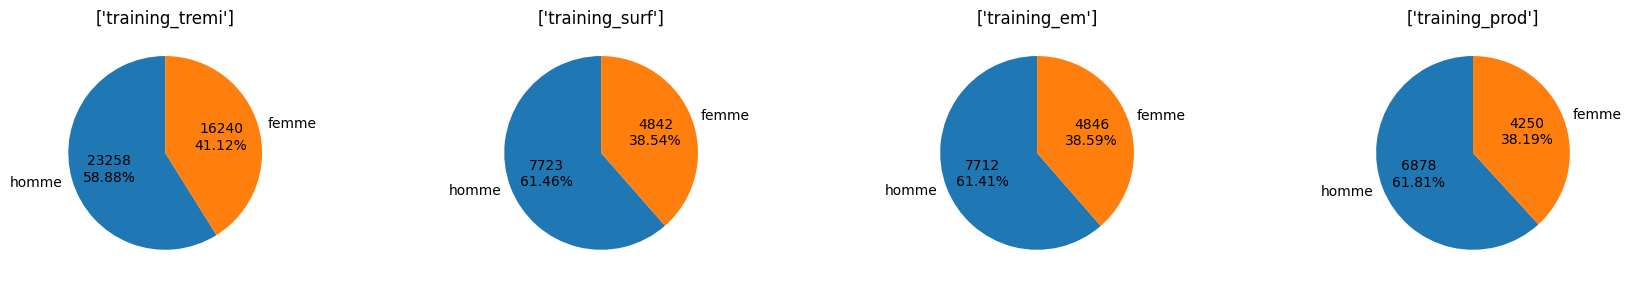

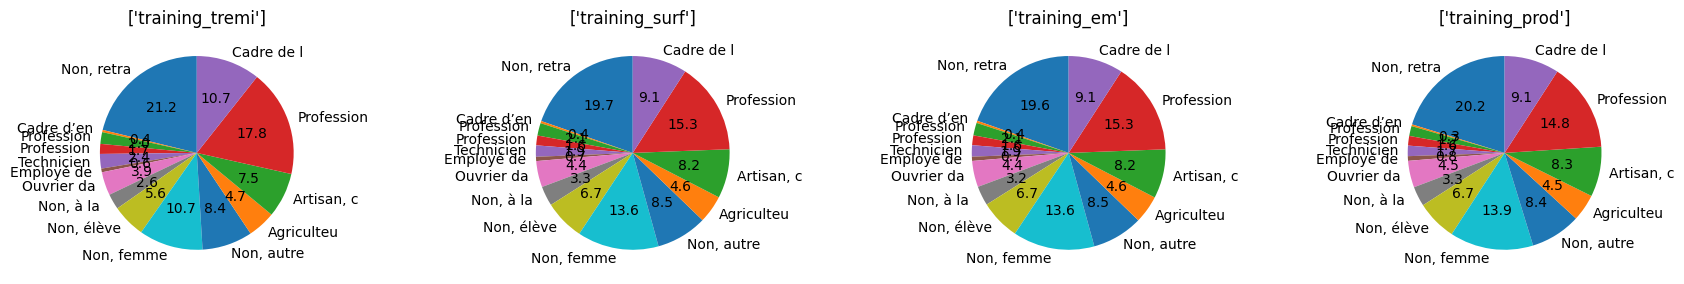

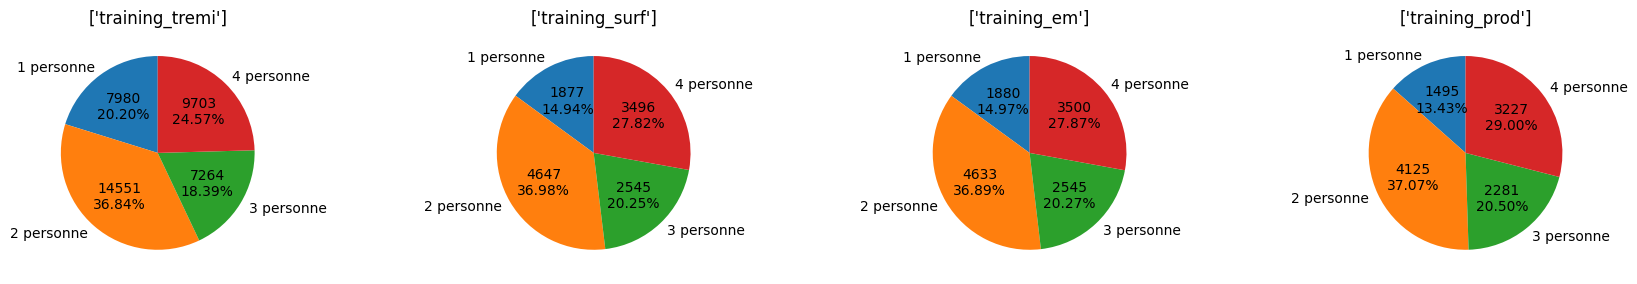

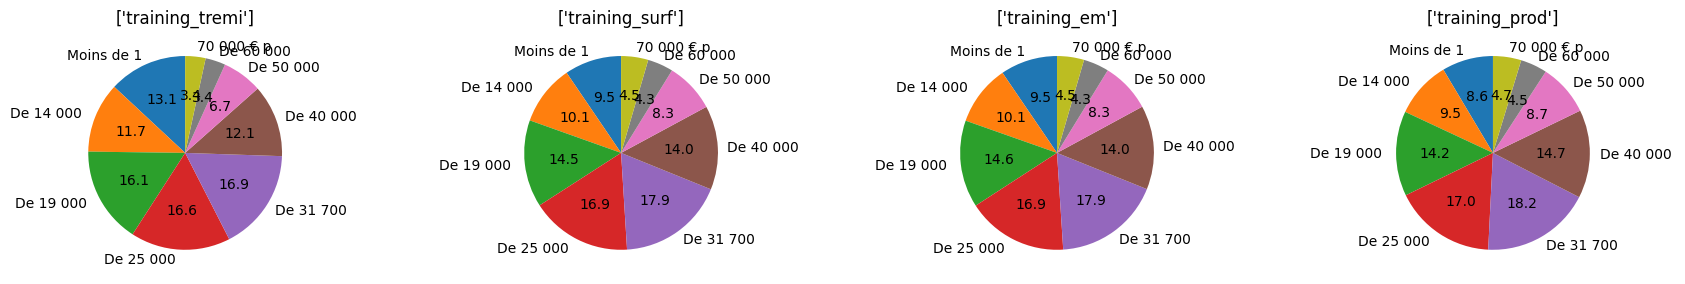

In [89]:

dfs = [training_tremi, training_surf, training_em, training_prod]
compare_repartition(dfs, 'gender')
compare_repartition(dfs, 'occupation')
compare_repartition(dfs, 'nb_persons_home')
compare_repartition(dfs, 'income')



In [ ]:
def histo(df, variable, bins = 20):
    plt.hist(df.select(variable).toPandas(), bins)

(array([1046., 1419., 2289., 1029., 1234., 2151., 2775., 3199., 1288.,
        1941., 1556., 2099., 3541., 1285., 3030., 2638., 1593., 2072.,
        1164., 2149.]),
 array([ 1. ,  5.7, 10.4, 15.1, 19.8, 24.5, 29.2, 33.9, 38.6, 43.3, 48. ,
        52.7, 57.4, 62.1, 66.8, 71.5, 76.2, 80.9, 85.6, 90.3, 95. ]),
 <BarContainer object of 20 artists>)

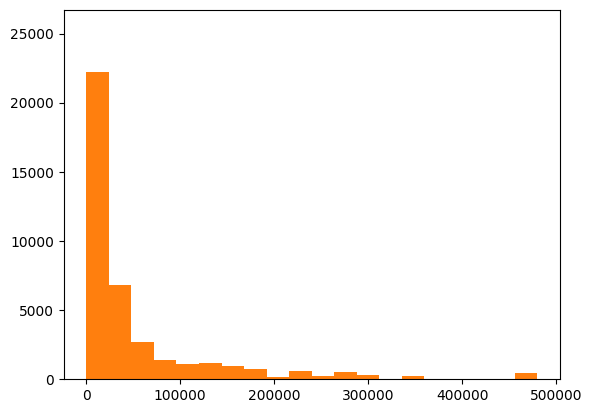

In [92]:
plt.hist(training_tremi.select('age').toPandas(), bins=20)
plt.hist(training_tremi.select('population').toPandas(), bins=20)
plt.hist(training_tremi.select('n_development_licence').toPandas(), bins=20)
plt.hist(training_tremi.select('n_construction_licence').toPandas(), bins=20)
plt.hist(training_tremi.select('n_destruction_licence').toPandas(), bins=20)
plt.hist(training_tremi.select('department_number').toPandas(), bins=20)